In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer

### Initial Data and Cleaning
---

In [106]:
df = pd.read_csv('./data/marketing_campaign.csv', delimiter='\t')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [107]:
df.shape

(2240, 29)

All data is accounted for except income.  To keep it simple, we will impute the mean into missing income.

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

As a personal preference I will make all column names lower case for easier typing.

In [109]:
df.columns = [x.lower() for x in df.columns]

In [110]:
mean_income = df['income'].mean()
mean_income

52247.25135379061

In [111]:
df['income'].fillna(mean_income, inplace=True)

### Feature Engineering
---

Features to engineer:
1. Customer involvement duration - how long has a customer been enrolled with the company
2. Total dependants - combined teens and children
3. Total spent - total amount spent across all categories
4. Customer age - how old the customer is
5. Partners - determine if the person is single or living with someone.
6. Total household size - total number of people in the household including parterns and children
7. Parental status - boolean column to identify parents
8. Total promos - total number of promotions accepted

First we must convert out 'dt_customer' column to proper datetime format.

In [112]:
df['dt_customer'] = pd.to_datetime(df['dt_customer'])

In order to get the account's age, we will subtract each account creation date from the newest account's date.

In [113]:
newest_acc = df['dt_customer'].max()
newest_acc

Timestamp('2014-12-06 00:00:00')

Loop through every account's creation date and subract the newest account's date to get the age of the account.

In [114]:
acc_age = []
for i in df['dt_customer']:
    diff = newest_acc - i
    acc_age.append(diff)

df['acc_age'] = acc_age
df['acc_age'] = pd.to_numeric(df['acc_age'].dt.days, downcast='integer')

Let's check the column to make sure it's displaying properly.  Looks good!

In [115]:
df['acc_age']

0       971
1       125
2       472
3        65
4       321
       ... 
2235    541
2236     61
2237    315
2238    316
2239    782
Name: acc_age, Length: 2240, dtype: int16

Next we will engineer the remainder of our features.

In [116]:
# total combined number of children (children plus teens)
df['total_children'] = df['kidhome'] + df['teenhome']

# total spent across all product categories
df['total_spent'] = df['mntwines'] + df['mntfruits'] + df['mntmeatproducts'] + df['mntfishproducts'] + df['mntsweetproducts'] + df['mntgoldprods']

# user's age
df['age'] = 2021 - df['year_birth']

# whether the person is living alone or with a partner (not including children)
df['partner'] = df['marital_status'].replace({'Married':1, 'Together':1, 'Absurd':0, 'Widow':0, 'YOLO':0, 'Divorced':0, 'Single':0, 'Alone': 0})
df['partner'] = [int(x) for x in df['partner']]

# total number of people in the household including the user, potential partner, and/or children
df['household_size'] = df['partner'].replace({1:2, 0:1}) + df['total_children']

# a boolean column identifying whether the person is a parent or not
df['parent'] = np.where(df['total_children'] > 1, 1, 0)

# total number of promotions accepted
df["total_promos"] = df["acceptedcmp1"]+ df["acceptedcmp2"]+ df["acceptedcmp3"]+ df["acceptedcmp4"]+ df["acceptedcmp5"]

Finally, we'll drop some redudant columns that no longer serve a purpose now that we've engineered some to be more useful features.

In [117]:
df.drop(columns=['marital_status', 'dt_customer', 'z_costcontact', 'z_revenue', 'year_birth', 'id'], inplace=True)
df.head()

,education,income,kidhome,teenhome,recency,mntwines,mntfruits,mntmeatproducts,mntfishproducts,mntsweetproducts,...,complain,response,acc_age,total_children,total_spent,age,partner,household_size,parent,total_promos
0,Graduation,58138.0,0,0,58,635,88,546,172,88,...,0,1,971,0,1617,64,0,1,0,0
1,Graduation,46344.0,1,1,38,11,1,6,2,1,...,0,0,125,2,27,67,0,3,1,0
2,Graduation,71613.0,0,0,26,426,49,127,111,21,...,0,0,472,0,776,56,1,2,0,0
3,Graduation,26646.0,1,0,26,11,4,20,10,3,...,0,0,65,1,53,37,1,3,0,0
4,PhD,58293.0,1,0,94,173,43,118,46,27,...,0,0,321,1,422,40,1,3,0,0


### EDA
---

We have some very wealthy patrons throwing off our histogram, but we can see most of our users' incomes follow a relatively normal distribution between 0 and $100,000

In [118]:
df.columns

Index(['education', 'income', 'kidhome', 'teenhome', 'recency', 'mntwines',
       'mntfruits', 'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts',
       'mntgoldprods', 'numdealspurchases', 'numwebpurchases',
       'numcatalogpurchases', 'numstorepurchases', 'numwebvisitsmonth',
       'acceptedcmp3', 'acceptedcmp4', 'acceptedcmp5', 'acceptedcmp1',
       'acceptedcmp2', 'complain', 'response', 'acc_age', 'total_children',
       'total_spent', 'age', 'partner', 'household_size', 'parent',
       'total_promos'],
      dtype='object')

In [119]:
cleaned_income = df[df['income'] < 200000]

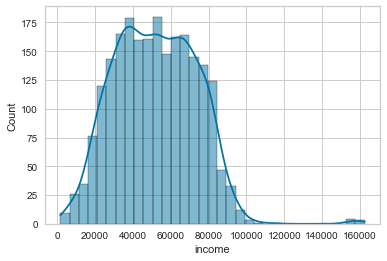

In [120]:
sns.histplot(cleaned_income['income'], kde=True);

A uniform distribution of the number of days between when a person purchased an item.  No clear pattern or bell curve here.

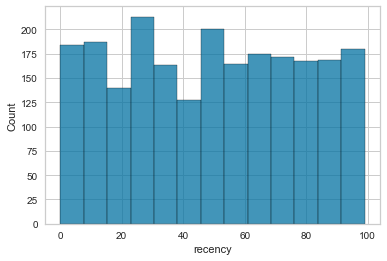

In [121]:
sns.histplot(df['recency']);

Distribution of the total household size is relatively regular.  Most households are between 2 and 4 people indicating:
1. Most users are couples or single parents with a single child
2. Most users are a couple with multiple children or a single parent with multiple children

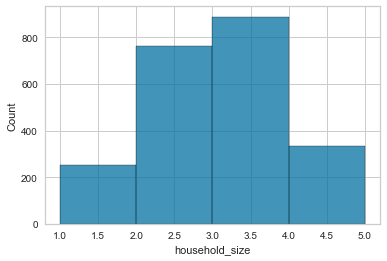

In [122]:
sns.histplot(df['household_size'], bins=4);

The distribution of age is not perfectly clear but we can see a vast majority of users are between 45-50 years old.

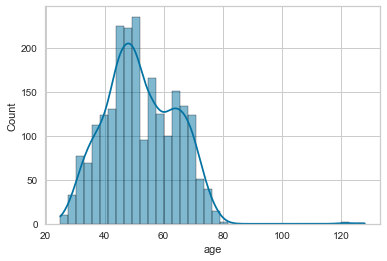

In [123]:
sns.histplot(df['age'], kde=True);

Comparing income to spending and removing folks who make over 200k, we can see a logarithmic increase in spending as income goes up, peaking between those who make $80k - 100k

For our modeling purposes later we will need to consider removing the additional income outliers above $120k.

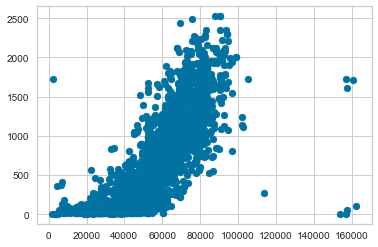

In [124]:
plt.scatter(cleaned_income['income'], cleaned_income['total_spent']);

I'm curious if there are any correlation between people purchasing certain items together, so we'll make a heatmap and examine those possible correlations.  These may be disposable correlations since people likely tend to buy multiple items, but the strongest correlations we might want to consider are:
1. Wine and meat
2. Fruit and fish
3. Fruit and sweets

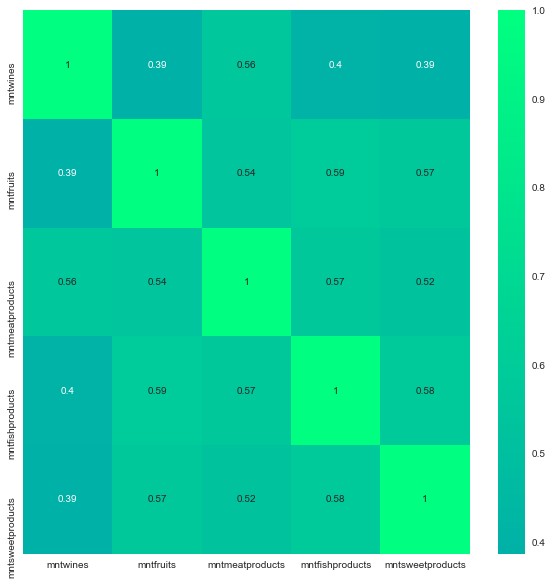

In [125]:
corrmat= df.iloc[:, 5:10].corr()
plt.figure(figsize=(10,10))  
sns.heatmap(corrmat,annot=True, cmap='winter', center=0);

In [126]:
df = df[df['income'] < 200000]

In [127]:
df.shape

(2239, 31)

In [128]:
df.reset_index(inplace=True)

### Pre-processing
---

Before modeling there are a handful of things that need to happen:
- Encode our non-numerical and categorical variables
- Scale our data
- Dimensionality reduction

In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2239 entries, 0 to 2238
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                2239 non-null   int64  
 1   education            2239 non-null   object 
 2   income               2239 non-null   float64
 3   kidhome              2239 non-null   int64  
 4   teenhome             2239 non-null   int64  
 5   recency              2239 non-null   int64  
 6   mntwines             2239 non-null   int64  
 7   mntfruits            2239 non-null   int64  
 8   mntmeatproducts      2239 non-null   int64  
 9   mntfishproducts      2239 non-null   int64  
 10  mntsweetproducts     2239 non-null   int64  
 11  mntgoldprods         2239 non-null   int64  
 12  numdealspurchases    2239 non-null   int64  
 13  numwebpurchases      2239 non-null   int64  
 14  numcatalogpurchases  2239 non-null   int64  
 15  numstorepurchases    2239 non-null   i

Our only categorical column that needs to be dummied is income so we'll use Pandas' built in dummy feature to encode that column.

In [130]:
df = pd.get_dummies(df, columns=['education'])
df.head()

,index,income,kidhome,teenhome,recency,mntwines,mntfruits,mntmeatproducts,mntfishproducts,mntsweetproducts,...,age,partner,household_size,parent,total_promos,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD
0,0,58138.0,0,0,58,635,88,546,172,88,...,64,0,1,0,0,0,0,1,0,0
1,1,46344.0,1,1,38,11,1,6,2,1,...,67,0,3,1,0,0,0,1,0,0
2,2,71613.0,0,0,26,426,49,127,111,21,...,56,1,2,0,0,0,0,1,0,0
3,3,26646.0,1,0,26,11,4,20,10,3,...,37,1,3,0,0,0,0,1,0,0
4,4,58293.0,1,0,94,173,43,118,46,27,...,40,1,3,0,0,0,0,0,0,1


Next we will scale our data.

In [131]:
sc = StandardScaler()
scaled_df = sc.fit_transform(df)

We now have 34 total features, many of which are correlated and therefore unneccessary to us.  To refine our data we will perform PCA, or principal component analysis to find the most important features.  It looks like the PCA algorithm reduced our dimensions from 34 to 18, meaning 18 of our features fit into the specified 95% variance requirement.

In [132]:
pca = PCA(n_components = 0.95)
pca.fit(scaled_df)
reduced = pd.DataFrame(pca.transform(scaled_df))
reduced.shape

(2239, 25)

Since we will be clustering to find our different user groups, we want to find the ideal number of clusters.  We will use the elbow method to find this number.

From the below graph, it appears that 5 will be the optimal number for us.

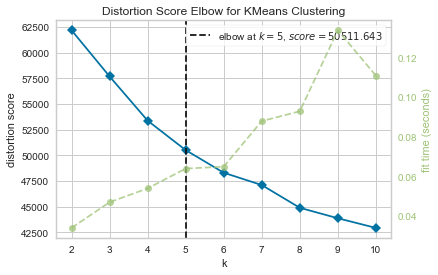

In [133]:
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(reduced)
Elbow_M.show();

In [134]:
#Initiating the Agglomerative Clustering model 
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(reduced)
reduced["clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
df["clusters"]= yhat_AC

Checking the distribution of our clusters. We can see that a vast majority fall into group 0 and 3 with a consistent decline after that.

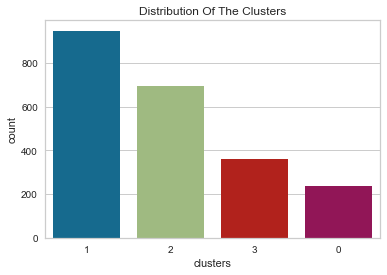

In [135]:
pl = sns.countplot(x=df["clusters"], order= df['clusters'].value_counts().index)
pl.set_title("Distribution Of The Clusters")
plt.show()

Next, let's explore the clusters distributed by income and spending.

From the below graph we can infer:
- Group 0: high income and medium spending
- Group 1: low income and low spending
- Group 2: high income and high spending
- Group 3: medium income and low spending

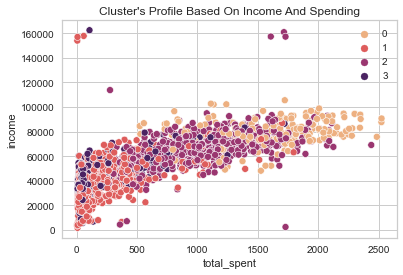

In [136]:
pl = sns.scatterplot(data = df,x=df["total_spent"], y=df["income"],hue=df["clusters"], palette='flare')
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

Promotions and coupons draw in a lot of business, often times getting people's feet in the door to make more purchases while taking advantage of the promotion.  Let's see how our groups interact with our promotions.

It appears that most people did not take advantage of promotions.

Solutions:
1. Target promotions more accurately to the correct audience.
2. Target high popularity items to draw more people
3. Depending on inventory, target low selling items to move them

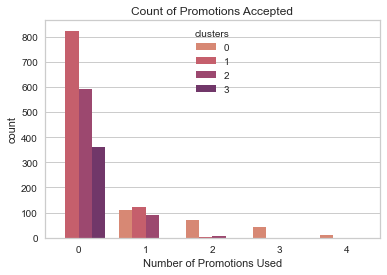

In [137]:
plt.figure()
pl = sns.countplot(x=df['total_promos'], hue=df['clusters'], palette='flare')
pl.set_title('Count of Promotions Accepted')
pl.set_xlabel('Number of Promotions Used')
plt.show();

Deals on the other hand are utilized much more often by customers seeing a resounding number of users using 1 or 2 deals with 3-7 trailing off consistently.  This is a much more successful selling tool for us.

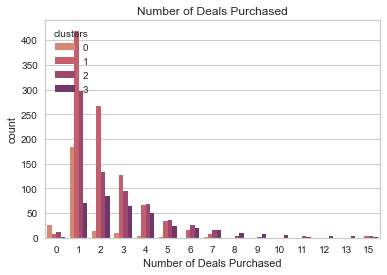

In [138]:
plt.figure()
pl = sns.countplot(x=df['numdealspurchases'], hue=df['clusters'], palette='flare')
pl.set_title('Number of Deals Purchased')
pl.set_xlabel('Number of Deals Purchased')
plt.show();

In [139]:
df.columns

Index(['index', 'income', 'kidhome', 'teenhome', 'recency', 'mntwines',
       'mntfruits', 'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts',
       'mntgoldprods', 'numdealspurchases', 'numwebpurchases',
       'numcatalogpurchases', 'numstorepurchases', 'numwebvisitsmonth',
       'acceptedcmp3', 'acceptedcmp4', 'acceptedcmp5', 'acceptedcmp1',
       'acceptedcmp2', 'complain', 'response', 'acc_age', 'total_children',
       'total_spent', 'age', 'partner', 'household_size', 'parent',
       'total_promos', 'education_2n Cycle', 'education_Basic',
       'education_Graduation', 'education_Master', 'education_PhD',
       'clusters'],
      dtype='object')

In [149]:
cl0 = []
cl1 = []
cl2 = []
cl3 = []

for i in range(df.shape[0]):
    if df['clusters'][i] == 0:
        cl0.append(df['age'][i])
    elif df['clusters'][i] == 1:
        cl1.append(df['age'][i])
    elif df['clusters'][i] == 2:
        cl2.append(df['age'][i])
    elif df['clusters'][i] == 3:
        cl3.append(df['age'][i])

print("Cluster 0's average age is:", np.mean(cl0))
print("Cluster 1's average age is:", np.mean(cl1))
print("Cluster 2's average age is:", np.mean(cl2))
print("Cluster 3's average age is:", np.mean(cl3))
        

Cluster 0's average age is: 52.445378151260506
Cluster 1's average age is: 49.11193241816262
Cluster 2's average age is: 54.3982683982684
Cluster 3's average age is: 55.905817174515235


In [150]:
cl0 = []
cl1 = []
cl2 = []
cl3 = []

for i in range(df.shape[0]):
    if df['clusters'][i] == 0:
        cl0.append(df['parent'][i])
    elif df['clusters'][i] == 1:
        cl1.append(df['parent'][i])
    elif df['clusters'][i] == 2:
        cl2.append(df['parent'][i])
    elif df['clusters'][i] == 3:
        cl3.append(df['parent'][i])

print("Cluster 0's average age is:", np.mean(cl0))
print("Cluster 1's average age is:", np.mean(cl1))
print("Cluster 2's average age is:", np.mean(cl2))
print("Cluster 3's average age is:", np.mean(cl3))

Cluster 0's average age is: 0.012605042016806723
Cluster 1's average age is: 0.0908130939809926
Cluster 2's average age is: 0.03607503607503607
Cluster 3's average age is: 0.997229916897507


In [ ]:
cl0 = []
cl1 = []
cl2 = []
cl3 = []

for i in range(df.shape[0]):
    if df['clusters'][i] == 0:
        cl0.append(df['total_children'][i])
    elif df['clusters'][i] == 1:
        cl1.append(df['total_children'][i])
    elif df['clusters'][i] == 2:
        cl2.append(df['total_children'][i])
    elif df['clusters'][i] == 3:
        cl3.append(df['total_children'][i])

print("Cluster 0's average age is:", np.mean(cl0))
print("Cluster 1's average age is:", np.mean(cl1))
print("Cluster 2's average age is:", np.mean(cl2))
print("Cluster 3's average age is:", np.mean(cl3))